In [10]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE, simulate_for_sbi
from sbi.neural_nets import posterior_nn
import torch
import matplotlib.pyplot as plt
from sbi import analysis

import time

import torch
import torch.nn as nn

from sbi import utils as sbi_utils
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [17]:
# Configuration
num_samples = 100
t_max = 20
num_timesteps = 64
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)
num_simulations=100000

In [18]:
# [WALL]--(k0,b0)--[m0]--(k1,b1)--[m1]--(k2,b2)--[m2]

# Define system of equations
def multi_mass_spring_damper(y, t, m, k, b, F_ext=None):
    """
    y: concatenated [x0, x1, ..., xn, v0, v1, ..., vn]
    m, k, b: arrays of length n
    F_ext: optional external force per mass at time t
    """
    n = len(m)
    x = y[:n]
    v = y[n:]
    
    dxdt = v
    dvdt = np.zeros(n)

    for i in range(n):
        # External force
        F = 0
        if F_ext is not None:
            F = np.interp(t, t_data, F_ext[i])
        else:
            F = 2

        # Spring-damper forces from neighbors
        force = 0

        # Left spring/damper: wall or previous mass
        if i == 0: 
         force += -k[0] * x[0] - b[0] * v[0]  # connected to wall
        else:
            force += -k[i] * (x[i] - x[i-1]) - b[i] * (v[i] - v[i-1])

        # Right spring/damper: next mass if not last
        if i < n - 1:
            force += -k[i+1] * (x[i] - x[i+1]) - b[i+1] * (v[i] - v[i+1])

        dvdt[i] = (F + force) / m[i]

    return np.concatenate([dxdt, dvdt])


def multi_msd_simulator(params, F_ext=None):
    """
    params: [m0, m1, ..., k0, k1, ..., b0, b1, ...]
    """
    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return extract_summary_statistics_multimass(t, x, v)

def multi_msd_simulator_raw(params, F_ext=None):

    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return t, x, v


def extract_summary_statistics_multimass(t, x, v):
    num_masses = x.shape[1]

    # Compute stats per mass
    stats = []
    for i in range(num_masses):
        stats.extend(extract_summary_statistics(t, x[:, i], v[:, i]))

    return np.array(stats)


def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats

def generate_deterministic_force(timesteps, num_masses, seed=42, smoothing=2.0):
    rng = np.random.default_rng(seed)
    raw = rng.random(timesteps) - 0.5
    force = np.cumsum(raw)
    force = gaussian_filter1d(force, sigma=smoothing)
    force = np.abs(force)
    return np.tile(force, (num_masses, 1)) 

def generate_stochastic_force(timesteps, num_masses, seed=None, smoothing=1.5):
    rng = np.random.default_rng(seed)
    # Random walk force signal
    F_shared = np.abs(np.cumsum(rng.random(timesteps) - 0.5))
    # Optional smoothing
    if smoothing is not None and smoothing > 0:
        F_shared = gaussian_filter1d(F_shared, sigma=smoothing)
    # Tile for each mass
    return np.tile(F_shared, (num_masses, 1))

def simulator(params):

    F_ext = generate_stochastic_force(num_timesteps, num_masses)

    # F_ext = generate_deterministic_force(num_timesteps, num_masses)

    # F_ext = np.abs(np.cumsum(np.random.rand(num_masses, num_timesteps) - 0.5, axis=1))

    return multi_msd_simulator(params, F_ext=F_ext)


def plot_posterior_prediction_band(
    posterior,
    x_o,
    simulator_raw,
    force_func,
    mass_index=0,
    num_samples=100,
    show_samples=False,
    plot_position=True,
    plot_velocity=True,
    color='C0',
    label='Posterior Predictive'
):
    import matplotlib.pyplot as plt
    import numpy as np

    x_trajectories = []
    v_trajectories = []
    t_ref = None

    theta_samples = posterior.sample((num_samples,), x=x_o).numpy().squeeze()
    for theta_sample in theta_samples:
        t, x, v = simulator_raw(theta_sample, force_func())
        if t_ref is None:
            t_ref = t
        x_trajectories.append(x[:, mass_index])
        v_trajectories.append(v[:, mass_index])

    x_trajectories = np.stack(x_trajectories)
    v_trajectories = np.stack(v_trajectories)

    def plot_quantile_bands(data, t, base_color, variable_name):
        # CI levels from narrow (dense) to wide
        quantiles = [50, 70, 90]
        alphas = [0.25, 0.18, 0.12]
        for q, alpha in zip(quantiles, alphas):
            lower = np.percentile(data, 50 - q / 2, axis=0)
            upper = np.percentile(data, 50 + q / 2, axis=0)
            plt.fill_between(t, lower, upper, color=base_color, alpha=alpha,
                             label=f'{label} ${variable_name}_{mass_index}$ ({q}% CI)' if q == 90 else None)

        median = np.median(data, axis=0)
        plt.plot(t, median, color=base_color, lw=2, label=f'{label} ${variable_name}_{mass_index}$ (Median)')

    if plot_position:
        plot_quantile_bands(x_trajectories, t_ref, base_color=color, variable_name='x')
        if show_samples:
            for traj in x_trajectories:
                plt.plot(t_ref, traj, color=color, alpha=0.05, lw=0.6)

    if plot_velocity:
        plot_quantile_bands(v_trajectories, t_ref, base_color='C1', variable_name='v')
        if show_samples:
            for traj in v_trajectories:
                plt.plot(t_ref, traj, color='C1', alpha=0.05, lw=0.6)


def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels



def stack_xv(x, v):
    """
    Stack position and velocity arrays into channel-first format.
    Input:
        x, v: arrays of shape [timesteps, num_masses]
    Returns:
        stacked: [2 * num_masses, timesteps]
    """
    x = np.asarray(x).T  # [num_masses, timesteps]
    v = np.asarray(v).T
    return np.vstack([x, v])  # [2*num_masses, timesteps]

class HybridEmbedding(nn.Module):
    def __init__(self, seq_embed_net, seq_len, stats_dim=10, num_masses=1, fused_dim=10):
        super().__init__()
        self.seq_embed_net = seq_embed_net
        self.stats_dim = stats_dim
        self.seq_shape = (2 * num_masses, seq_len)

        self.stats_fc = nn.Sequential(
            nn.Linear(stats_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.fusion = nn.Sequential(
            nn.Linear(16 + fused_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):  # x shape: [batch, (2*num_masses)*seq_len + stats_dim]
        seq_flat = x[:, :-self.stats_dim]
        stats = x[:, -self.stats_dim:]

        # Reshape to [B, 2*num_masses, T]
        seq = seq_flat.view(x.shape[0], *self.seq_shape)

        seq_embed = self.seq_embed_net(seq)
        stats_embed = self.stats_fc(stats)

        combined = torch.cat([seq_embed, stats_embed], dim=1)
        return self.fusion(combined)

class LSTMEmbedding(nn.Module):
    def __init__(self, num_masses, hidden_size=64, output_size=10, num_layers=1):
        super().__init__()
        self.input_size = 2 * num_masses  # x and v per mass

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.output_net = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        # x shape: [batch_size, channels=2*num_masses, time]
        x = x.permute(0, 2, 1)  # [batch_size, time, channels]
        _, (hn, _) = self.lstm(x)  # [num_layers, batch, hidden]
        embedding = hn[-1]  # last layer’s hidden state
        return self.output_net(embedding)
    

def msd_hybrid(theta, simulator_raw, summary_fn, force_fn):
    """
    Creates a hybrid input vector by combining trajectory sequence and summary statistics.

    Parameters:
        theta: Parameter vector (e.g., shape [12])
        simulator_raw: Function that returns (t, x, v)
        summary_fn: Callable that takes (t, x, v) and returns summary stats
        force_fn: Callable that generates external force

    Returns:
        hybrid_vector: Flattened [2 * num_masses * timesteps + stats_dim] vector (float32)
    """
    t, x, v = simulator_raw(theta, F_ext=force_fn())
    seq = stack_xv(x, v)  # Shape: [2 * num_masses, timesteps]
    stats = summary_fn(t, x, v)  # e.g., shape [10]

    # Flatten and concatenate
    hybrid_vector = np.concatenate([seq.flatten(), stats], axis=0)
    return hybrid_vector.astype(np.float32)

/tmp/ipykernel_16078/4080973950.py:63: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  m = np.array(params[:num_masses])
/tmp/ipykernel_16078/4080973950.py:64: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  k = np.array(params[num_masses:2*num_masses])
/tmp/ipykernel_16078/4080973950.py:65: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see t


=== Running simulation with 2 masses ===



100%|██████████| 100000/100000 [19:04<00:00, 87.36it/s]


Simulation time: 1144.87 seconds (19.08 minutes)
 Neural network successfully converged after 293 epochs.Training time: 3692.74 seconds (61.55 minutes)


Drawing 100000 posterior samples: 101451it [00:00, 117017.30it/s]                           


True vs Inferred parameters:
T m0: 7.9208, I m0: 7.2282, Abs Err: 0.6926, Rel Err: 8.74%
T m1: 2.7849, I m1: 2.4906, Abs Err: 0.2943, Rel Err: 10.57%
T k0: 3.6254, I k0: 3.4132, Abs Err: 0.2123, Rel Err: 5.85%
T k1: 3.0636, I k1: 2.9923, Abs Err: 0.0713, Rel Err: 2.33%
T b0: 4.7277, I b0: 6.2119, Abs Err: 1.4842, Rel Err: 31.39%
T b1: 2.5896, I b1: 3.1568, Abs Err: 0.5671, Rel Err: 21.90%

Error Metrics:
Mean Squared Error (MSE): 0.523489
Average Absolute Error: 0.553630
Average Relative Error: 13.46%
Avg Error by Parameter Type:
  Masses (m): 9.66%
  Spring Constants (k): 4.09%
  Damping Coefficients (b): 26.65%


Drawing 100 posterior samples: 185it [00:00, 9298.56it/s]             


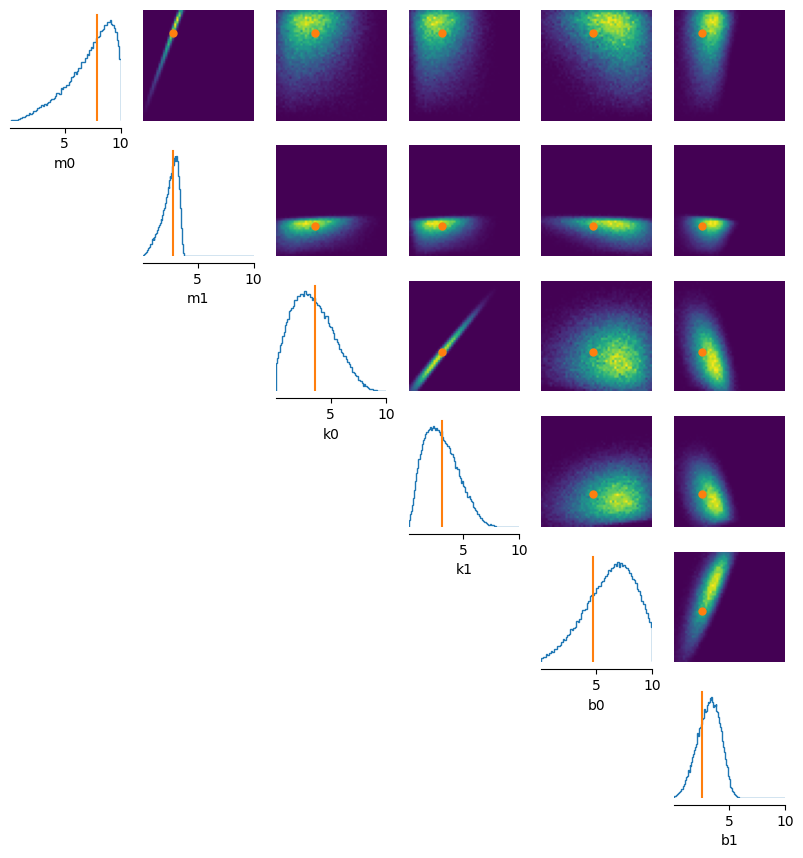

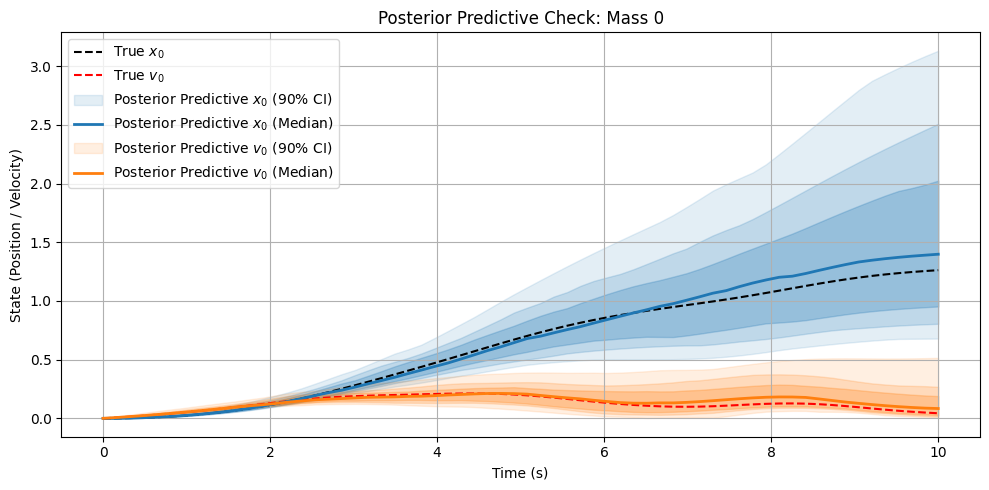

Drawing 100 posterior samples: 175it [00:00, 8089.53it/s]             


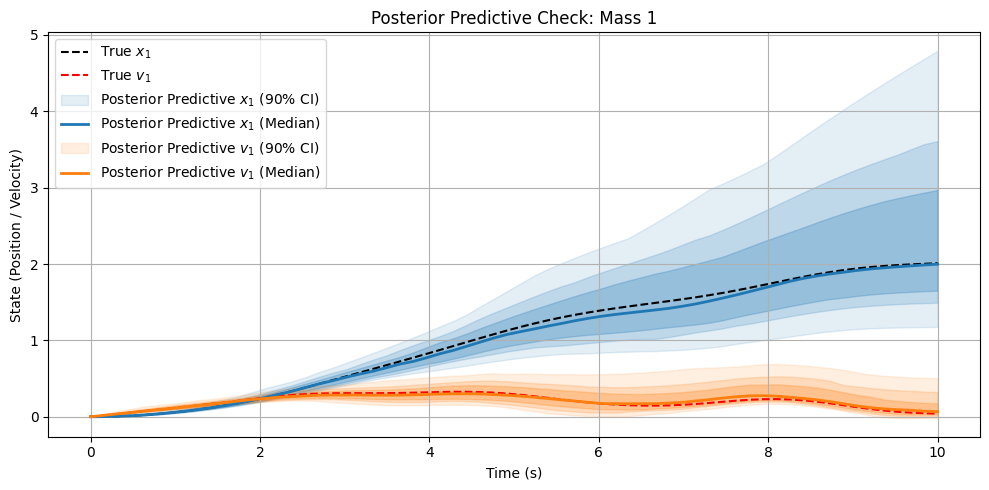


=== Running simulation with 3 masses ===



100%|██████████| 100000/100000 [28:21<00:00, 58.77it/s]


Simulation time: 1701.97 seconds (28.37 minutes)
 Neural network successfully converged after 302 epochs.Training time: 3387.53 seconds (56.46 minutes)


Drawing 100000 posterior samples: 102193it [00:01, 75017.55it/s]                           


True vs Inferred parameters:
T m0: 3.7594, I m0: 4.1619, Abs Err: 0.4025, Rel Err: 10.71%
T m1: 5.5660, I m1: 7.3021, Abs Err: 1.7361, Rel Err: 31.19%
T m2: 2.3451, I m2: 1.9537, Abs Err: 0.3914, Rel Err: 16.69%
T k0: 5.7686, I k0: 4.9147, Abs Err: 0.8539, Rel Err: 14.80%
T k1: 7.8403, I k1: 6.8768, Abs Err: 0.9635, Rel Err: 12.29%
T k2: 3.0695, I k2: 2.0804, Abs Err: 0.9891, Rel Err: 32.22%
T b0: 3.6263, I b0: 4.6533, Abs Err: 1.0270, Rel Err: 28.32%
T b1: 6.0015, I b1: 6.4845, Abs Err: 0.4830, Rel Err: 8.05%
T b2: 0.4948, I b2: 4.0296, Abs Err: 3.5347, Rel Err: 714.36%

Error Metrics:
Mean Squared Error (MSE): 2.194172
Average Absolute Error: 1.153478
Average Relative Error: 96.51%
Avg Error by Parameter Type:
  Masses (m): 19.53%
  Spring Constants (k): 19.77%
  Damping Coefficients (b): 250.24%


Drawing 100 posterior samples: 161it [00:00, 5108.77it/s]             


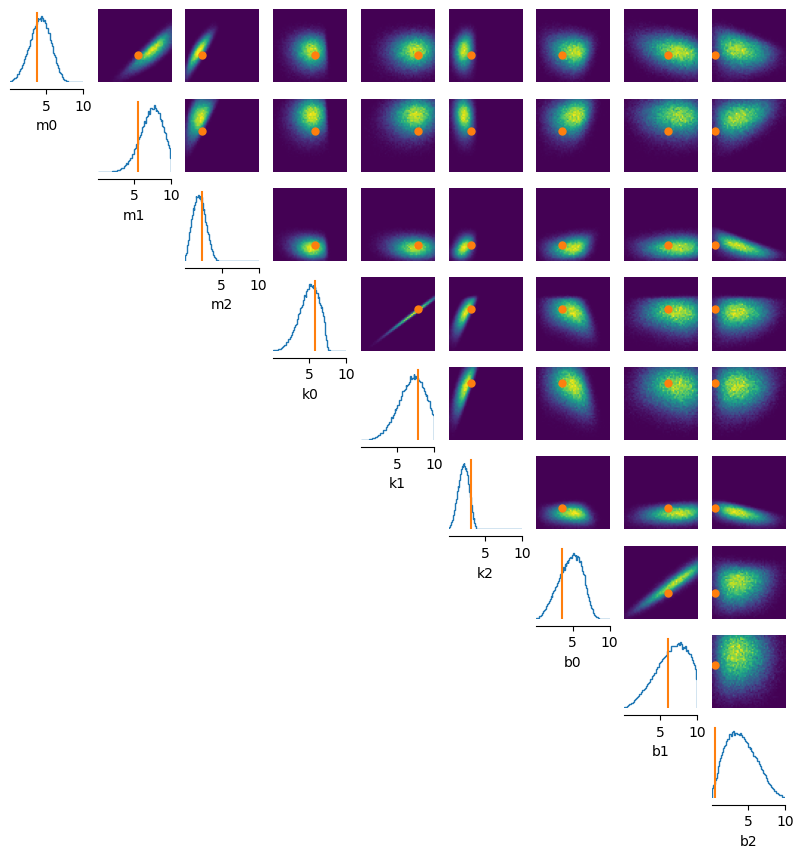

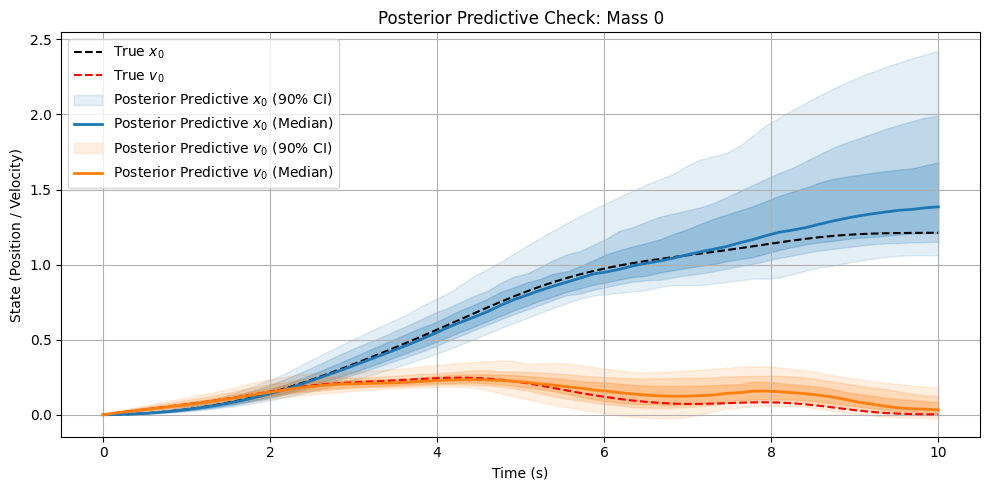

Drawing 100 posterior samples: 154it [00:00, 5083.48it/s]             


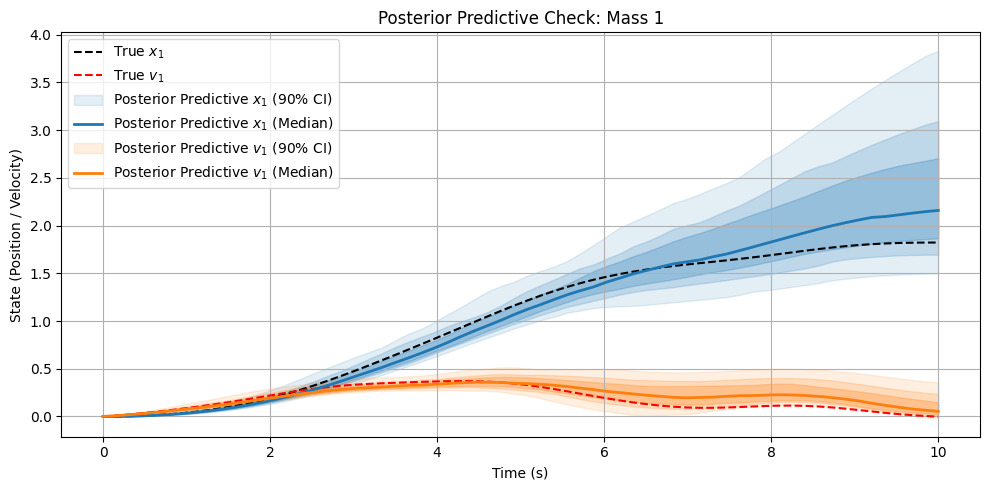

Drawing 100 posterior samples: 154it [00:00, 4480.60it/s]             


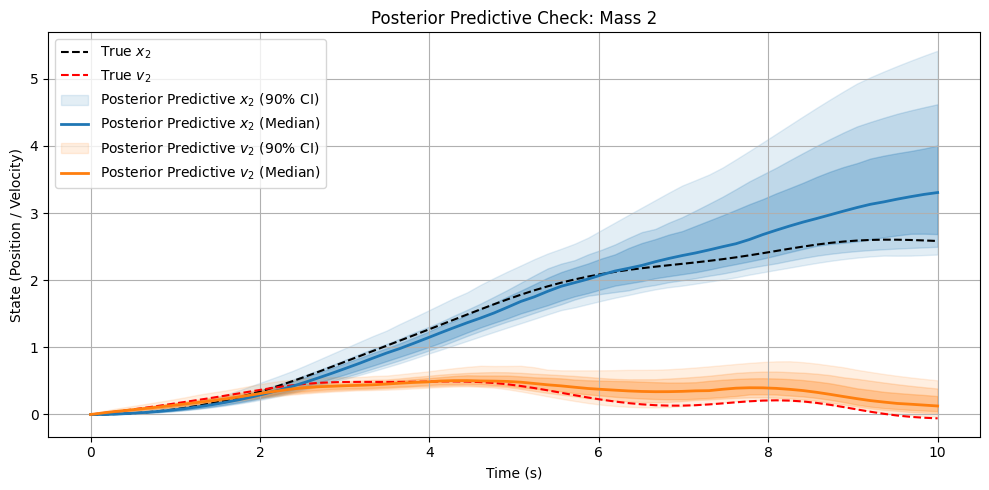


=== Running simulation with 4 masses ===



100%|██████████| 100000/100000 [37:16<00:00, 44.70it/s]


Simulation time: 2237.20 seconds (37.29 minutes)
 Neural network successfully converged after 321 epochs.Training time: 3422.37 seconds (57.04 minutes)


Drawing 100000 posterior samples: 100713it [00:03, 33388.21it/s]                           


True vs Inferred parameters:
T m0: 9.2972, I m0: 6.9084, Abs Err: 2.3888, Rel Err: 25.69%
T m1: 3.6456, I m1: 2.4904, Abs Err: 1.1552, Rel Err: 31.69%
T m2: 1.8874, I m2: 3.5305, Abs Err: 1.6431, Rel Err: 87.05%
T m3: 5.4250, I m3: 4.2433, Abs Err: 1.1817, Rel Err: 21.78%
T k0: 7.3480, I k0: 7.9226, Abs Err: 0.5746, Rel Err: 7.82%
T k1: 3.6777, I k1: 4.2752, Abs Err: 0.5976, Rel Err: 16.25%
T k2: 6.3327, I k2: 6.0990, Abs Err: 0.2337, Rel Err: 3.69%
T k3: 1.4745, I k3: 0.9959, Abs Err: 0.4786, Rel Err: 32.46%
T b0: 8.2999, I b0: 7.2571, Abs Err: 1.0428, Rel Err: 12.56%
T b1: 4.6851, I b1: 3.0234, Abs Err: 1.6617, Rel Err: 35.47%
T b2: 3.4214, I b2: 4.8162, Abs Err: 1.3948, Rel Err: 40.77%
T b3: 0.9185, I b3: 2.8125, Abs Err: 1.8939, Rel Err: 206.19%

Error Metrics:
Mean Squared Error (MSE): 1.790750
Average Absolute Error: 1.187208
Average Relative Error: 43.45%
Avg Error by Parameter Type:
  Masses (m): 41.55%
  Spring Constants (k): 15.05%
  Damping Coefficients (b): 73.75%


Drawing 100 posterior samples: 137it [00:00, 3300.40it/s]             


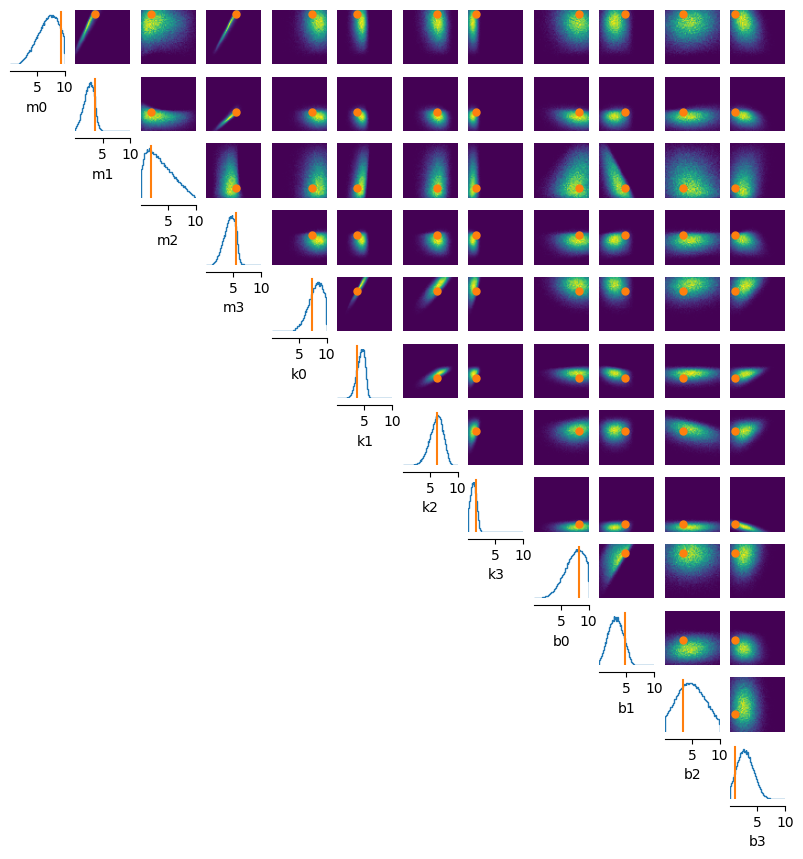

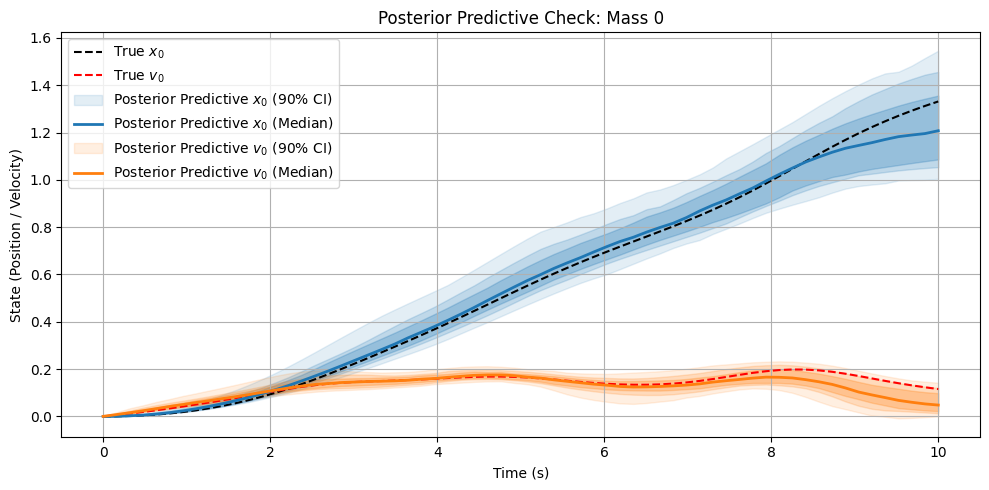

Drawing 100 posterior samples: 130it [00:00, 3012.02it/s]             


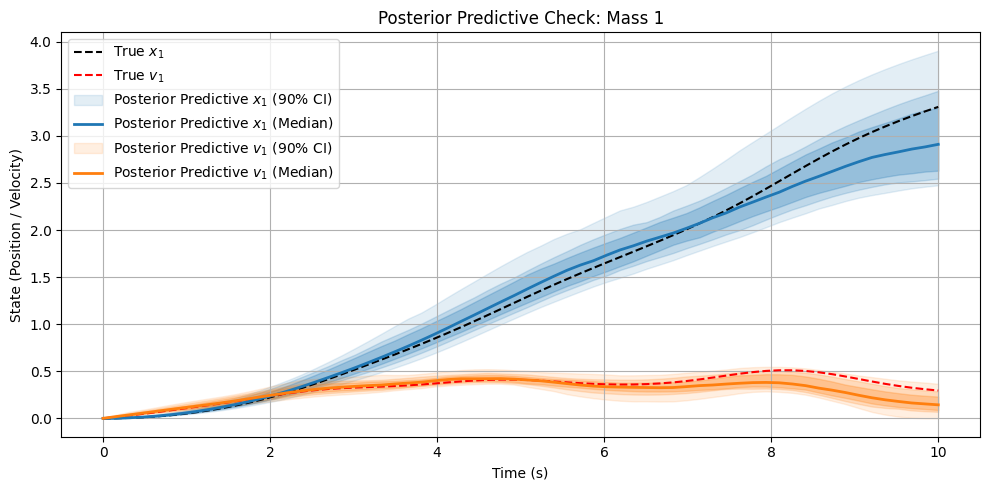

Drawing 100 posterior samples: 144it [00:00, 2599.29it/s]             


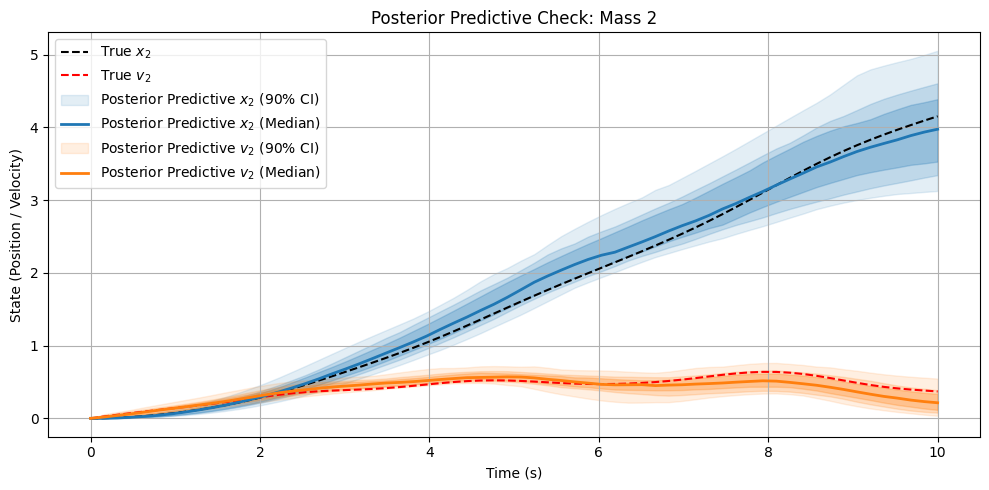

Drawing 100 posterior samples: 130it [00:00, 2513.04it/s]             


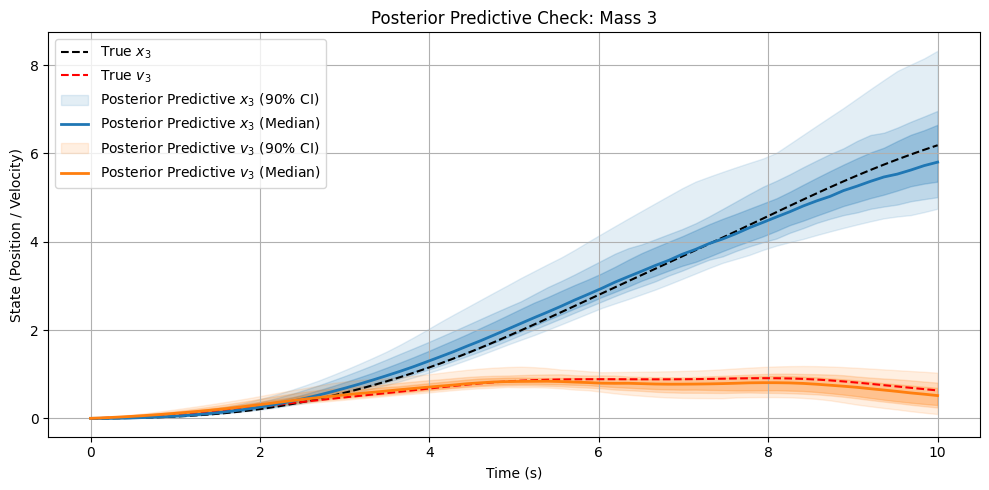

In [19]:
for num_masses in [2, 3, 4]:
    print(f"\n=== Running simulation with {num_masses} masses ===\n")
    
    # Prior distribution for (m, k, b) — assuming you know rough ranges
    num_params = 3 * num_masses 

    prior = sbi_utils.BoxUniform(
        low=torch.tensor([0.1] * num_params),
        high=torch.tensor([10.0] * num_params)
    )

    prior, num_parameters, prior_returns_numpy = process_prior(prior)

    sample = prior.sample((1,))
    force_func = lambda: generate_stochastic_force(num_timesteps, num_masses, 42)

    sequence_net = LSTMEmbedding(num_masses)
    embedding_net = HybridEmbedding(seq_embed_net=sequence_net, stats_dim=11*num_masses, num_masses=num_masses, seq_len=num_timesteps)

    density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
    inference = NPE(prior=prior, density_estimator=density_estimator)

    simulator_wrapper = process_simulator(
        lambda theta: msd_hybrid(
            theta,
            simulator_raw=multi_msd_simulator_raw,
            summary_fn=extract_summary_statistics_multimass,
            force_fn=lambda: generate_stochastic_force(num_timesteps, num_masses) # must use seed of zero here
        ),
        prior,
        prior_returns_numpy
    )
    
    # Track simulation time
    sim_start_time = time.time()
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
    sim_time = time.time() - sim_start_time
    print(f"Simulation time: {sim_time:.2f} seconds ({sim_time/60:.2f} minutes)")
    
    # Track training time
    train_start_time = time.time()
    _ = inference.append_simulations(theta, x).train()
    train_time = time.time() - train_start_time
    print(f"Training time: {train_time:.2f} seconds ({train_time/60:.2f} minutes)")
    
    posterior = inference.build_posterior()

    force_func2 = generate_stochastic_force(num_timesteps, num_masses, 42)
    observed_data = msd_hybrid(
            sample.numpy()[0],
            simulator_raw=multi_msd_simulator_raw,
            summary_fn=extract_summary_statistics_multimass,
            force_fn=force_func
        )
    observed_data = torch.tensor(observed_data, dtype=torch.float32)
    
    # Infer parameters
    samples = posterior.sample((100000,), x=observed_data)
    # Get posterior mean (or median)
    mean_sample = samples.mean(dim=0)  # shape: (3 * num_masses,)
    params, labels = get_param_labels_and_values(mean_sample, num_masses)
    
    # Calculate error metrics
    abs_error = torch.abs(mean_sample - sample[0])
    mse = torch.mean((mean_sample - sample[0])**2).item()
    rel_error = abs_error / sample[0] * 100  # percentage error
    avg_abs_error = torch.mean(abs_error).item()
    avg_rel_error = torch.mean(rel_error).item()
    
    print("True vs Inferred parameters:")
    for i, label in enumerate(labels):
        print(f"T {label}: {sample[0][i]:.4f}, I {label}: {params[i]:.4f}, Abs Err: {abs_error[i]:.4f}, Rel Err: {rel_error[i]:.2f}%")
    
    print(f"\nError Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Average Absolute Error: {avg_abs_error:.6f}")
    print(f"Average Relative Error: {avg_rel_error:.2f}%")
    
    # Group errors by parameter type (masses, spring constants, damping)
    mass_errors = rel_error[0:num_masses].mean().item()
    k_errors = rel_error[num_masses:2*num_masses].mean().item()
    b_errors = rel_error[2*num_masses:3*num_masses].mean().item()
    
    print(f"Avg Error by Parameter Type:")
    print(f"  Masses (m): {mass_errors:.2f}%")
    print(f"  Spring Constants (k): {k_errors:.2f}%")
    print(f"  Damping Coefficients (b): {b_errors:.2f}%")

    fig, ax = analysis.pairplot(
        samples,
        points=sample,
        labels=labels,
        limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
    )

    # Ground truth trajectory
    true_params = sample.flatten()
    t_real, x_real, v_real = multi_msd_simulator_raw(true_params, force_func())
    x_o = msd_hybrid(        
            true_params,
            simulator_raw=multi_msd_simulator_raw,
            summary_fn=extract_summary_statistics_multimass,
            force_fn=force_func
        )

    # Plot for each mass
    for mass_index in range(num_masses):
        plt.figure(figsize=(10, 5))
        
        # True trajectories
        plt.plot(t_real, x_real[:, mass_index], '--k', label=f'True $x_{mass_index}$')
        plt.plot(t_real, v_real[:, mass_index], '--r', label=f'True $v_{mass_index}$')
        
        # Posterior predictions
        plot_posterior_prediction_band(
            posterior,
            x_o,
            simulator_raw=multi_msd_simulator_raw,
            force_func=force_func,
            mass_index=mass_index,
            num_samples=100,
            plot_position=True,
            plot_velocity=True,
            show_samples=False
        )
        
        plt.xlabel("Time (s)")
        plt.ylabel("State (Position / Velocity)")
        plt.title(f"Posterior Predictive Check: Mass {mass_index}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
# import pickle
# with open(f"./models/msd_hybrid_{num_simulations}.pkl", "wb") as handle:
#     pickle.dump(posterior, handle)

In [21]:
# with open(f"./models/msd_hybrid_{num_simulations}.pkl", "rb") as handle:
#     posterior = pickle.load(handle)

In [22]:
# T m0: 1.4746, I m0: 1.4631
# T k0: 9.4530, I k0: 9.4857
# T b0: 5.9971, I b0: 5.9304